In [1]:
## Visualisation for Univariate Quantile Encoder-Decoder Long Short-Term Memory model (QEDLSTM)
## by Jimmy Cheung

In [2]:
## No need to carry out multiple (30) experiments and calculate RMSE, MAE, MAPE here
## No need to ask for model specification here, if wish to change parameters please do so manually

In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt   
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
# wraps dataset into tensor -> appropriate for pytorch -> DataLoader
class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, decoder_inputs, outputs):
        self.inputs = inputs
        self.decoder_inputs = decoder_inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        decoder_input = self.decoder_inputs[idx]
        y = self.outputs[idx]
        return (torch.tensor(x, dtype=torch.float32), 
        	torch.tensor(decoder_input, dtype=torch.float32), 
        	torch.tensor(y, dtype=torch.float32))

In [5]:
## Quantile Version
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(Encoder, self).__init__()
        # If int, wrap in list for uniform handling
        if isinstance(hidden_sizes, int):
            hidden_sizes = [hidden_sizes]
        self.hidden_sizes = hidden_sizes

        # Create stacked LSTMs
        self.lstms = nn.ModuleList()
        for i in range(len(hidden_sizes)):
            in_size = input_size if i == 0 else hidden_sizes[i - 1]
            out_size = hidden_sizes[i]
            self.lstms.append(nn.LSTM(in_size, out_size, batch_first=True))

    def forward(self, x):
        batch_size = x.size(0)
        for lstm in self.lstms:
            h0 = torch.zeros(1, batch_size, lstm.hidden_size).to(x.device)
            c0 = torch.zeros(1, batch_size, lstm.hidden_size).to(x.device)
            x, (h, c) = lstm(x, (h0, c0))
        return h, c

In [6]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_quantiles):
        super(Decoder, self).__init__()
        # If int, wrap in list for uniform handling
        if isinstance(hidden_sizes, int):
            hidden_sizes = [hidden_sizes]
        self.hidden_sizes = hidden_sizes
        self.num_quantiles = num_quantiles

        self.lstms = nn.ModuleList() # Create stacked LSTMs
        for i in range(len(hidden_sizes)):
            in_size = input_size if i == 0 else hidden_sizes[i - 1]
            out_size = hidden_sizes[i]
            self.lstms.append(nn.LSTM(in_size, out_size, batch_first=True))

        # Fully connected layer maps final hidden state to quantiles
        self.fc = nn.Linear(hidden_sizes[-1], num_quantiles)

    def forward(self, x, h, c):
        batch_size = x.size(0)
        for lstm in self.lstms:
            h0 = torch.zeros(1, batch_size, lstm.hidden_size).to(x.device)
            c0 = torch.zeros(1, batch_size, lstm.hidden_size).to(x.device)
            x, (h, c) = lstm(x, (h0, c0))
        out = self.fc(x)
        out = out.view(out.size(0), out.size(1), self.num_quantiles)
        return out, h, c

In [7]:
class QEDLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_quantiles):
        super(QEDLSTM, self).__init__()
        self.encoder = Encoder(input_size, hidden_sizes)
        self.decoder = Decoder(1, hidden_sizes, num_quantiles)

    def forward(self, encoder_inputs, decoder_inputs):
        h, c = self.encoder(encoder_inputs)
        decoder_inputs = decoder_inputs.unsqueeze(-1)
        outputs, _, _ = self.decoder(decoder_inputs, h, c)
        return outputs

In [8]:
# Additional function for quantile regression - Quantile loss function 
def quantile_loss(preds, target, quantiles): 
	losses = [] # idea is the same as tilted loss
	for i, quantile in enumerate(quantiles):
		errors = targets[:, :, i] - preds[:, :, i]
		losses.append(torch.mean(torch.max((quantile - 1) * errors, 
			quantile * errors)))
	return torch.mean(torch.stack(losses))

In [9]:
def evaluate_model(model, test_dataloader, quantiles):
	model.eval() 
	y_hat, y_true = [], []

	with torch.no_grad(): # disable gradient calculation
		for x, y in test_dataloader:
			y = y.unsqueeze(-1).expand(-1, -1, len(quantiles)) 
			outputs = model(x) # forward pass
			y_hat.append(outputs)
			y_true.append(y)
	y_hat = torch.cat(y_hat, dim = 0)
	y_true = torch.cat(y_true, dim = 0)
	return y_hat, y_true

In [10]:
# Univariate data processing
def split_series(series, input_size, output_size, train_ratio, seed):
    X, y, decoder_inputs = [], [], []
    total_size = input_size + output_size
    for i in range(len(series) - total_size + 1):
        X.append(series[i:i + input_size]) # encoder input
        # target output (the future sequence)
        y.append(series[i + input_size:i + total_size])
        # decoder input (previous target shifted by one step)
        decoder_inputs.append(
            series[i + input_size - 1:i + input_size + output_size - 1])
    # Split into train/test
    (X_train, X_test, y_train, y_test, decoder_train, 
    	decoder_test) = train_test_split(
        X, y, decoder_inputs, train_size=train_ratio, random_state=seed)
    return X_train, X_test, y_train, y_test, decoder_train, decoder_test

In [11]:
# Lorenz
def lorenz(xyz, *, s=10, r=28, b=2.667):
	x, y, z = xyz
	x_dot = s*(y - x)
	y_dot = r*x - y - x*z
	z_dot = x*y - b*z
	return np.array([x_dot, y_dot, z_dot])

In [12]:
# DATA HANDLING - CHANGE DATA AS DESIRED
# FOR LORENZ, CHANGE DIM = 0,1,2 FOR X,Y,Z VALUES

# data = 'bitcoin'
# data = 'ethereum'
# data = 'sunspots'
# data = 'mackey-glass'
data = 'lorenz'

if data == 'bitcoin' or data == 'ethereum':
    if data == 'bitcoin':
        df = pd.read_csv('../data/bitcoin.csv')
    else:
        df = pd.read_csv('../data/ethereum.csv')
    target = df.iloc[:,4].copy() # only interested in close price
elif data == 'sunspots':
    df = pd.read_csv('../data/sunspots.csv')
    target = df['Monthly Mean Total Sunspot Number']
elif data == 'mackey-glass' or data == 'lorenz':
    if data == 'mackey-glass':
        from reservoirpy.datasets import mackey_glass 
        df = mackey_glass(n_timesteps = 3000, tau=75, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
    else:
        dt = 0.01
        num_steps = 3000
        dim = 2 # x-dim: 0, y-dim: 1, z-dim: 2
        xyzs = np.empty((num_steps+1, 3))  
        xyzs[0] = (0., 1., 1.05)  
        for i in range(num_steps):
            xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt
        df = xyzs[:, dim] 
    df = df.flatten()
    target = pd.Series(df, name = 'Value')
    target.index = range(len(target))

target_reshaped = np.array(target).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1)) # normalise response variable
target_scaled = scaler.fit_transform(target_reshaped).flatten()

In [13]:
# PARAMETERS - we are setting fixed values here (same values as our paper)
input_size = 6
output_size = 5
train_ratio = 0.7
seed = 5925

quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
num_quantiles = len(quantiles) 

# Hyperparameters
num_features = 1
hidden_size = [64, 32]
num_epochs = 100

In [14]:
X_train, X_test, y_train, y_test, decoder_train, decoder_test = split_series(target_scaled, input_size, output_size, train_ratio, seed)
train_dataset = Time_Series_Dataset(X_train, decoder_train, y_train)
test_dataset = Time_Series_Dataset(X_test, decoder_test, y_test)
# changing batch size affect model accuracy significantly
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) 
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# EDLSTM-Q
model = QEDLSTM(num_features, hidden_size, num_quantiles)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [15]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for encoder_inputs, decoder_inputs, targets in train_dataloader:
        # Determine batch size dynamically
        batch_size = encoder_inputs.shape[0]
        # Correctly reshape the inputs
        encoder_inputs = encoder_inputs.view(
            batch_size, input_size, num_features)
        decoder_inputs = decoder_inputs.view(batch_size, output_size)
        # Add feature dimension
        targets = targets.view(batch_size, output_size, 1)  
        outputs = model(encoder_inputs, decoder_inputs) # forward pass
        # Reshape outputs to match targets
        outputs = outputs.view(batch_size, output_size, num_quantiles)
        # Expand targets to match the number of quantiles
        targets = targets.repeat(1, 1, num_quantiles)  
        loss = quantile_loss(outputs, targets, quantiles) # Compute loss

        optimizer.zero_grad() # Backward and optimize
        loss.backward()
        optimizer.step()

In [16]:
model.eval()
y_pred, y_test = [], []

with torch.no_grad():
    for encoder_inputs, decoder_inputs, targets in test_dataloader:
        # Determine batch size dynamically
        batch_size = encoder_inputs.shape[0]
        # Correctly reshape the inputs
        encoder_inputs = encoder_inputs.view(
            batch_size, input_size, num_features)
        decoder_inputs = decoder_inputs.view(batch_size, output_size)
        # Add feature dimension
        targets = targets.view(batch_size, output_size, 1) 

        # Forward pass
        outputs = model(encoder_inputs, decoder_inputs)
        # Reshape outputs
        outputs = outputs.view(batch_size, output_size, num_quantiles)  

        y_pred.append(outputs.numpy())
        # Expand targets to match the number of quantiles
        y_test.append(targets.repeat(1, 1, num_quantiles).numpy())  

# Convert lists to numpy arrays
pred_vals = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)[:, :, 0]

results = {q: None for q in quantiles} # dictionary
for a, q in enumerate(quantiles):
    results[q] = pred_vals[:, :, a]

In [17]:
predicted_005 = scaler.inverse_transform(results[0.05])
predicted_025 = scaler.inverse_transform(results[0.25])
predicted_050 = scaler.inverse_transform(results[0.50])
predicted_075 = scaler.inverse_transform(results[0.75])
predicted_095 = scaler.inverse_transform(results[0.95])
actual_values = scaler.inverse_transform(y_test)

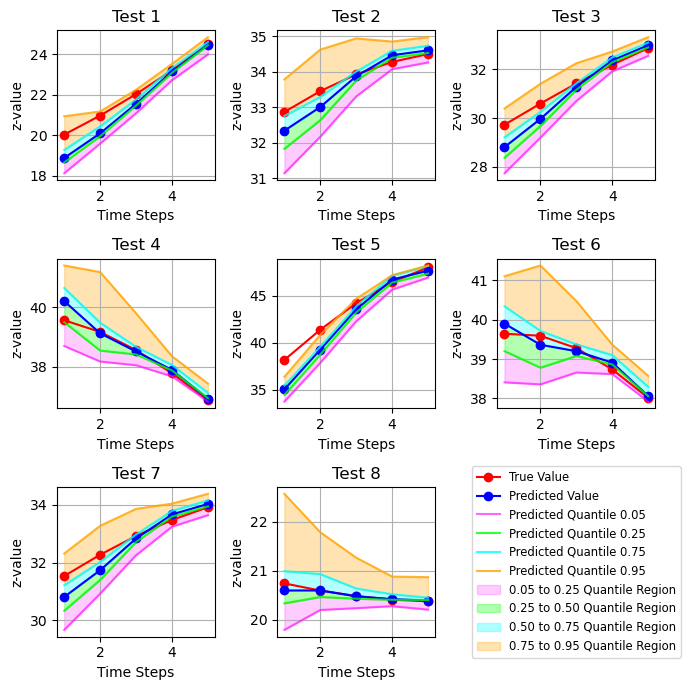

In [18]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='red', label='True Value')
    ax.plot(time_steps, predicted_050[i], marker='o', linestyle='-', color='blue', label='Predicted Value')
    
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='magenta', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='lime', label='Predicted Quantile 0.25', alpha=0.8)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='cyan', label='Predicted Quantile 0.75', alpha=0.8)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='orange', label='Predicted Quantile 0.95', alpha=0.8)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='magenta', alpha=0.2, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='lime', alpha=0.3, label='0.25 to 0.50 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='cyan', alpha=0.3, label='0.50 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='orange', alpha=0.3, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Test {i+1}')
    if data == 'bitcoin' or data == 'ethereum':
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Price (USD)')
    elif data == 'sunspots':
        ax.set_xlabel('Months')
        ax.set_ylabel('Number of Sunspots')
    elif data == 'mackey-glass':
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Amplitude')
    elif data == 'lorenz':
        ax.set_xlabel('Time Steps')
        if dim == 0:
            ax.set_ylabel('x-value')
        elif dim == 1:
            ax.set_ylabel('y-value')
        elif dim == 2:
            ax.set_ylabel('z-value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()

if data == 'bitcoin':
    plt.savefig('results/edlstm/univariate/BTC-U-QEDLSTM.png')
elif data == 'ethereum':
    plt.savefig('results/edlstm/univariate/ETH-U-QEDLSTM.png')
elif data == 'sunspots':
    plt.savefig('results/edlstm/univariate/Sunspots-QEDLSTM.png')
elif data == 'mackey-glass':
    plt.savefig('results/edlstm/univariate/MG-QEDLSTM.png')
elif data == 'lorenz':
    if dim == 0: # X-dim
        plt.savefig('results/edlstm/univariate/LorenzX-QEDLSTM.png')
    elif dim == 1:
        plt.savefig('results/edlstm/univariate/LorenzY-QEDLSTM.png')
    elif dim == 2:
        plt.savefig('results/edlstm/univariate/LorenzZ-QEDLSTM.png')

plt.show()
plt.close()